In [1]:
!pip install scikit-learn==1.3.2  # Ensure compatible version
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 56.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.3.2 which is incompatible.


In [2]:
# Load DT data (named features, no scaling/PCA)
# Adjust slug if your dataset name differs (e.g., from preprocessing output)
train_path = '/kaggle/input/telco-train-test-split-dataset/train_dt.csv'  # Resampled train
test_path = '/kaggle/input/telco-train-test-split-dataset/test_dt.csv'     # Original test split

In [3]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [4]:
X_train = df_train.drop('Churn', axis=1)
y_train = df_train['Churn']
X_test = df_test.drop('Churn', axis=1)
y_test = df_test['Churn']

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(X_train.head())  # Verify named features like 'gender', 'tenure'

Train shape: (8278, 30), Test shape: (1409, 30)
   gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       1              0        0           0      35             0   
1       1              0        1           1      15             1   
2       1              0        1           1      13             0   
3       0              0        1           0      26             1   
4       1              0        1           1       1             1   

   PaperlessBilling  MonthlyCharges  TotalCharges  \
0                 0           49.20       1701.65   
1                 0           75.10       1151.55   
2                 0           40.55        590.35   
3                 1           73.50       1905.70   
4                 0           44.55         44.55   

   MultipleLines_No phone service  ...  TechSupport_Yes  \
0                            True  ...            False   
1                           False  ...            False   
2                            

In [5]:
# Hyperparameter Tuning with GridSearchCV
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']  # Handle imbalance if no SMOTE used
}

dt = DecisionTreeClassifier(random_state=42)
grid_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='f1', n_jobs=-1)  # F1 for imbalance; parallel jobs
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='f1')

In [6]:
# Best model and results
best_dt = grid_dt.best_estimator_
print(f"Best DT Params: {grid_dt.best_params_}")
print(f"Best CV F1 Score: {grid_dt.best_score_:.4f}")

Best DT Params: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best CV F1 Score: 0.8032


In [7]:
# Predictions on test
y_pred_dt = best_dt.predict(X_test)
y_prob_dt = best_dt.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

In [8]:
# Evaluation Metrics
metrics_dt = {
    'Accuracy': accuracy_score(y_test, y_pred_dt),
    'Precision': precision_score(y_test, y_pred_dt),
    'Recall': recall_score(y_test, y_pred_dt),
    'F1-Score': f1_score(y_test, y_pred_dt),
    'ROC-AUC': roc_auc_score(y_test, y_prob_dt)
}
print("DT Test Metrics:", metrics_dt)

DT Test Metrics: {'Accuracy': 0.7381121362668559, 'Precision': 0.5053763440860215, 'Recall': 0.6283422459893048, 'F1-Score': 0.5601907032181167, 'ROC-AUC': 0.7811400449507866}


In [9]:
# Save metrics table for report
pd.DataFrame(list(metrics_dt.items()), columns=['Metric', 'Value']).to_csv('/kaggle/working/dt_metrics.csv', index=False)

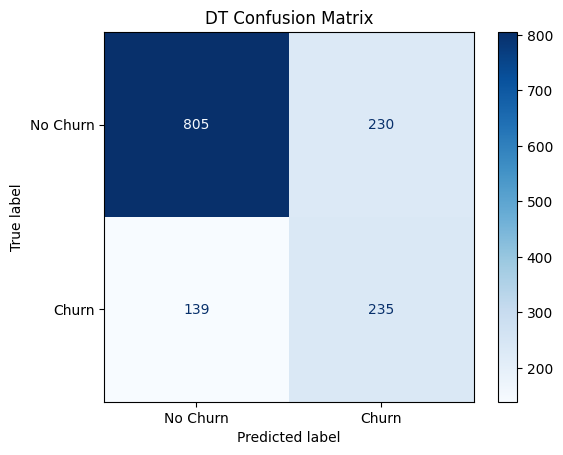

In [10]:
# Visualizations
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_dt)
ConfusionMatrixDisplay(cm, display_labels=['No Churn', 'Churn']).plot(cmap='Blues')
plt.title('DT Confusion Matrix')
plt.savefig('/kaggle/working/dt_confusion_matrix.png')
plt.show()

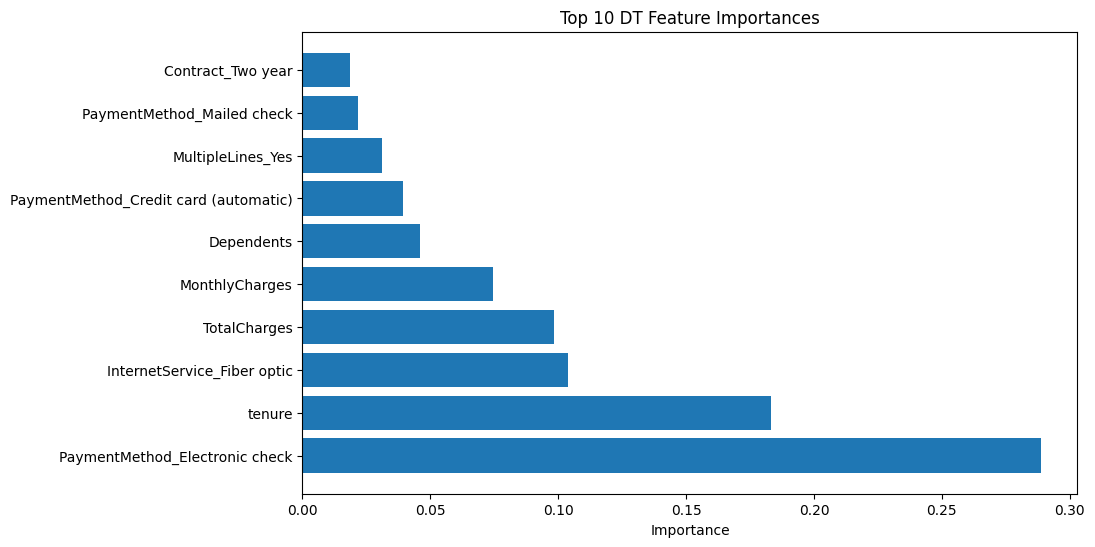

In [11]:
# Feature Importances (since named features)
importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': best_dt.feature_importances_})
importances = importances.sort_values('Importance', ascending=False).head(10)  # Top 10
plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'], importances['Importance'])
plt.title('Top 10 DT Feature Importances')
plt.xlabel('Importance')
plt.savefig('/kaggle/working/dt_feature_importances.png')
plt.show()

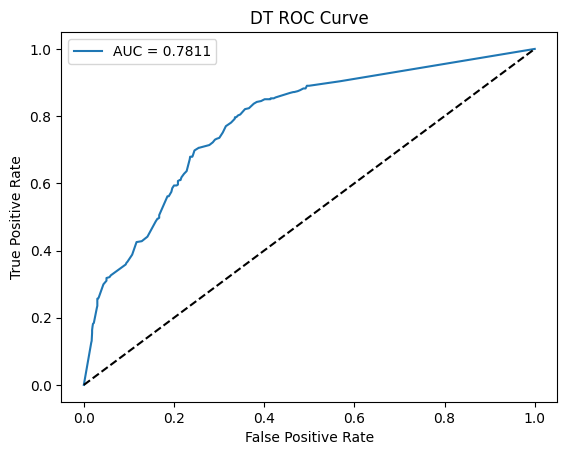

In [12]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_dt)
plt.plot(fpr, tpr, label=f'AUC = {metrics_dt["ROC-AUC"]:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DT ROC Curve')
plt.legend()
plt.savefig('/kaggle/working/dt_roc_curve.png')
plt.show()